# Actividad 4. Dirección de giro, señales de alto, autos, personas y semáforos en un video

## Librerias

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import time

## Variables globales

_______________
El primer paso a realizar es declarar los parámetros que usaremos, como el video usado para hacer la detección de objetos así como establecer la zona de interés en la cual estaremos trabajando durante todo el documento.
_______________

In [2]:
filePath = "videos/carretera_altos_peatones_automoviles.mp4"

In [3]:
#Poligono de área de interés
x1 = (180, 40)
x2 = (280, 40)
x3 = (160, 150)
x4 = (300, 150)

pts_poligono_fix = np.array([x3, x1, x2, x4], np.int32)
pts_poligono_fix = pts_poligono_fix.reshape((-1, 1, 2))

pts_poligono = np.array([x1, x2, x3, x4], np.int32)
pts_poligono = pts_poligono.reshape((-1, 1, 2))

## Función para la detección del giro

___________________
Se declara la funcion de binarización(la cual se logra aplicando diversos filtros al primer frame del video y así podamos enfocarnos en nuestro camino) para poder realizar la detección de dirección, ya que al binarizar estamos viendo lo que _ve_ la máquina,entonces gracias a la binarización es que podemos definiir los valores para el area de interés, punto medio y a partir de estos valores definir hacia que dirección se dirige el carrito.

Una vez que tenemos definida la dirección podemos darle un sentido a seguir a nuestras flechas, que son definididas a través de la librería de OpenCV con arrowedLine y con un punto de partida y otro de finalización.

Igualmente se puso un except a las funciones para las situaciones en la que nuestra zona de interés señalada no cuente con los datos necesarios para determinar la direccion.
___________________

In [4]:
def binarizacion(imagen):
    img = cv.cvtColor(imagen, cv.COLOR_BGR2RGB)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_gauss = cv.GaussianBlur(img_gray, (3, 3), 0)
    thr, img_thr = cv.threshold(img_gauss, 160, 255, cv.THRESH_BINARY)
    alto = img.shape[0]
    ancho = img.shape[1]
    ratio = 0.2
    img_r = cv.resize(img_thr, (480, 240), interpolation = cv.INTER_NEAREST)
    return(img_r)

In [5]:
def area_interes(imagen):
    pts1 = np.float32([x1, x2, x3, x4])
    pts2 = np.float32([[0, 0], [480, 0], [0, 240], [480, 240]])
    matrix = cv.getPerspectiveTransform(pts1, pts2)
    img_warp = cv.warpPerspective(imagen, matrix, (480, 240))
    return (img_warp)

In [6]:
def punto_medio(imagen):
    img_cercana= imagen[220:, :]
    suma_columnas = img_cercana.sum(axis=0)
    x_pos = np.arange(len(suma_columnas))
    try:
        mid_point=int( np.dot(x_pos,suma_columnas) / np.sum( suma_columnas ) )
        return mid_point
    except:
        print('no hay datos')
        return 'no hay datos'

In [7]:
#Funcion suma normalizada izquierda
def sum_izquierda(imagen, valor_punto_medio):
    if valor_punto_medio != 'no hay datos':
        return np.round(np.sum( imagen[:, :valor_punto_medio].sum(axis=0) )/(255*240*480),2)

In [8]:
#Funcion suma normalizada derecha
def sum_derecha(imagen, valor_punto_medio):
    if valor_punto_medio != 'no hay datos':
        return np.round(np.sum( imagen[:, valor_punto_medio:].sum(axis=0) )/(255*240*480),2)

In [9]:
def deteccion_direccion(imagen):
    img_bin = binarizacion(imagen) #binariza la imagen
    img_interes = area_interes(img_bin) #encuentra la zona de interes
    mid_point = punto_medio(img_interes) # encuentra el punto medio de la zona de interes
    
    #calculos de pixeles
    valor_sum_izquierda = sum_izquierda(img_interes, mid_point)
    valor_sum_derecha = sum_derecha(img_interes, mid_point)
    
    
    #cv.putText(img_interes, str(valor_sum_izquierda), org1, font, fontScale, color, thickness, cv.LINE_AA, False)
    #cv.putText(img_interes, str(valor_sum_derecha), org2, font, fontScale, color, thickness, cv.LINE_AA, False)
    try:
        delta = valor_sum_izquierda - valor_sum_derecha
    #print(delta)
    
        if delta > 0.07 :
            direccion = "izquierda"

            
        elif delta < -0.07 :
            direccion = "derecha"
            
        else:
            direccion = "adelante"
            
    #cv.putText(img_interes, movimiento, org3, font, fontScale, color, thickness, cv.LINE_AA, False)
        return direccion
    except:
        return 'No hay valores'

In [13]:
def flecha_print(imagen):
    img_bin = binarizacion(imagen) #binariza la imagen
    img_interes = area_interes(img_bin) #encuentra la zona de interes
    mid_point = punto_medio(img_interes) # encuentra el punto medio de la zona de interesimg_bin = binarizacion(image) #binariza la imagen
    img_interes = area_interes(img_bin) #encuentra la zona de interes
    mid_point = punto_medio(img_interes) # encuentra el punto medio de la zona de interes


    start_point = (0, 0) 
    end_point = (0, 1)
    # Green color in BGR  
    color = (0, 255, 0)
    # Line thickness of 9 px  
    thickness = 8
    image = cv.arrowedLine(image, start_point, end_point, 
                                     color, thickness)
                                     
    valor_sum_izquierda = sum_izquierda(img_interes, mid_point)
    valor_sum_derecha = sum_derecha(img_interes, mid_point)

    delta = valor_sum_izquierda - valor_sum_derecha
   

    #if direccion == 'derecha':
    if delta < -0.07:
        #imprime una flecha hacia la derecha jsjsjsjs
        start_point = (20, 20) 
        end_point = (60, 20)
        image = cv.arrowedLine(image, start_point, end_point, color, thickness)
        return image
    #elif direccion == 'izquierda':
    elif delta > 0.07:
        #imprime una flecha hacia la izquierda
        start_point = (60, 20) 
        end_point = (20, 20)
        image = cv.arrowedLine(image, start_point, end_point, 
                                   color, thickness)
        return image
    #elif direccion == 'adelante':
    else:
        #imprime una flecha hacia
        #except:
            #return 'No hay valores', adelante
        start_point = (20, 50) 
        end_point = (20, 20)
        image = cv.arrowedLine(image, start_point, end_point, color, thickness)

        return imagen
    except:
        return 'No hay valores'

SyntaxError: invalid syntax (<ipython-input-13-449eeb15c6ac>, line 49)

## Función para la detección de altos, carros y peatones

__________________
En este apartado se importaron los datos necesarios para la detección con Haar Cascade, y a apartir de ellos se definió una función para detectar los objetos dentro del video. Tanto la importación de los datos Haar Cascade y los dibujos realizados en la detección de los objetos fueron a través d ela librería de OpenCV.
__________________

In [10]:
#importando datos haar cascade
stop_cascade = cv.CascadeClassifier('datos/Stopsign_HAAR_19Stages.xml')
car_cascade = cv.CascadeClassifier('datos/cars.xml')
peaton_cascade = cv.CascadeClassifier('datos/haarcascade_fullbody.xml')


In [12]:
#definiendo funcion de deteccion
def video_detect(frame):
    
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    
    altos = stop_cascade.detectMultiScale(gray, 1.18, 5)
    autos = car_cascade.detectMultiScale(gray, 1.13, 5)
    peaton = peaton_cascade.detectMultiScale(gray, 1.11, 5)

    for (x, y, w, h) in autos:

        cv.rectangle(frame, (x, y), (x + w, y + h), (213,152,221), 2)
        cv.putText(frame, 'Carro', (x, y), 6, 0.8, (213,152,221), 2)

    for (x, y, w, h) in altos:

        cv.rectangle(frame, (x, y), (x + w, y + h), (76,163,221), 2)
        cv.putText(frame, 'Alto', (x, y), 6, 0.8, (76,163,221), 2)

    for (x, y, w, h) in peaton:

        cv.rectangle(frame, (x, y), (x + w, y + h), (13,236,175), 2)
        cv.putText(frame, 'Peaton', (x, y), 6, 0.8, (13,236,175), 2)


        fr_gray = gray[y:y + h, x:x + w]
        fr_color = frame[y:y + h, x:x + w]
        
    #return frame

## Función para la detección de semáforos

### Tratamiento de imagenes

________________________
Posteriormente, se aplica un filtro hsv para así poder hacer la separación por colores dentro del video, lo cual nos permititá ubicar las luces del semáforo, de manera que _separamos_ el color **verde, amarillo y rojo**.

Por último, antes de mostrar el video se realiza una función para ubicar los colores que estén dentro de una circunferencia, esto es para poder detectar la forma característica de los focos d eun semáforo, ya que así podríamos determinar si se trata de un **alto, adelante y/o precaución**.
________________________

In [13]:
def hsv_convert(image):
    return cv.cvtColor(image, cv.COLOR_BGR2HSV)

In [14]:
#definimos una función que retorne la mascara para el color verde
def green_finder(image):
    
    lower_green = np.array([34, 50, 232]) # 39, 50, 83
    upper_green = np.array([82, 255, 255])#91, 255, 255
    
    img_hsv = hsv_convert(image)
    mask_green = cv.inRange(img_hsv, lower_green, upper_green)
    
    return mask_green

In [15]:
#definimos una función que retorne la mascara para el color amarillo
def yellow_finder(image):
    
    lower_green = np.array([12, 43, 232])
    upper_green = np.array([53, 255, 255])

    img_hsv = hsv_convert(image)
    mask = cv.inRange(img_hsv, lower_green, upper_green)
    mask_green = mask
    
    return mask_green

In [19]:
#definimos una función que retorne la mascara para el color rojo
def red_finder(image):#
    lower_red1 = np.array([0,9,237])#0,65,100 older 0, 100, 100 
    upper_red1 = np.array([5,255,255]) #5,255,255
    lower_red2 = np.array([170,9,237]) #170,100,100
    upper_red2 = np.array([180,255,255]) #180,255,255
    
    img_hsv = hsv_convert(image)#
    
    mask1 = cv.inRange(img_hsv, lower_red1, upper_red1)
    mask2 = cv.inRange(img_hsv, lower_red2, upper_red2)
    
    mask_red = cv.add(mask1, mask2)
    
    return mask_red

### Circulos

In [16]:
def circle_finder(img):
    circles = cv.HoughCircles(img, cv.HOUGH_GRADIENT, 1, 30, param1 = 50, param2 = 5, minRadius = 0, maxRadius = 30)
    return circles

In [17]:
def print_circle(image, color_mask, label, gamma):
    
    #Estética de escritura
    font = cv.FONT_HERSHEY_SIMPLEX
    region = 5
    
    #Circulos
    circles = circle_finder(color_mask)

    #Entra si existe un circulo
    if circles is not None:
        
        circles = np.uint16(np.around(circles))
        print('In print_circle() color', label)
        
        #Para cada circulo
        for i in circles[0, :]:
            pixel_value = 0.0
            n = 0.0
            check = False
            
            for j in range(-region, region):
                for k in range(-region, region):
                    #print('region:', region)
                    #print('pixel_value:', pixel_value)
                    try:
                        pixel_value += color_mask[i[1]+j, i[0]+k]
                        
                    except:
                        print('In print_circle() data in bound')
                        
                    n += 1

            if pixel_value/n > gamma:
                print('In print_circle() passed gamma at:', pixel_value/n )
                cv.circle(image, (i[0], i[1]), i[2]+10, (0,255,0), 2)
                cv.putText(image, label, (i[0]-i[2], i[1]-i[2]-10), font, 1, (0, 255, 0), 2, cv.LINE_AA)
    
    return cv.cvtColor(image, cv.COLOR_BGR2RGB)

# Video

_____________________
Finalmente para mostrar la detección durante el video, declaramos una variable con el video e introducimos los valores que queremos para detalles tales como el color, la fuente, el tamaño de la fuente, etc. Igualmente declaramos que mientras el video se está reproduciendo se muestren las detecciones a través de las funciones que hemos realizado con anterioridad, de esta forma se desplegará el video con todas las detecciones realizadas.

**Observaciones**: No se pudo realizar la parada con la señalización de alto ya que no se dio de forma correcta la detección con el Haar Cascade, sim embargo, se realizó la parada con el semáforo en rojo. Igualmente no se imprimen las flechas ya que ocurrió un _error_ porque dentro de la zona de interés no hay suficientes datos para que se determine una dirección y eso hacía que se crasheara el video.
_____________________

In [20]:
video = cv.VideoCapture(filePath)
count = 1
stopCheck = False

cv.startWindowThread()

# font 
font = cv.FONT_HERSHEY_SIMPLEX 
# org 
org = (30, 50) 
fontScale = 1
# azul 
color = (255, 0, 0) 
thickness = 2

while(video.isOpened()):
    
    ret, frame = video.read()
    alto = frame.shape[0]
    ancho = frame.shape[1]
    ratio = 0.8
    frame = cv.resize(frame, ( int(ancho*ratio) , int(alto*ratio) ), interpolation=cv.INTER_NEAREST )
    
    if ret:
        #PRINT numero de frame
        print('In frame:', count)
        
        print('deteccion_direccion(frame):', deteccion_direccion(frame))
        
        print 
        #deteccion de semadoro en VERDE
        green_mask = green_finder(frame)
        semaforo_verde = print_circle(frame, green_mask, 'Verde', 20)
        RGB_fix = cv.cvtColor(semaforo_verde, cv.COLOR_BGR2RGB)
        
        
        #deteccion de semadoro en ROJO
        red_mask = red_finder(frame)
        semaforo_rojo = print_circle(frame, red_mask, 'Rojo', 29)
        RGB_fix = cv.cvtColor(semaforo_rojo, cv.COLOR_BGR2RGB)
        
        
        #deteccion de semadoro en AMARILLO
        yellow_mask = yellow_finder(frame)
        semaforo_amarillo = print_circle(frame, yellow_mask, 'Amarillo', 20)
        RGB_fix = cv.cvtColor(semaforo_amarillo, cv.COLOR_BGR2RGB)
        
        #detección de personas/carros/altos
        video_detect(frame)
    
        #detección de altos con numero de frame en esquina
        #print('altos_check()', altos_check(frame))
        #Detiene 3 segundos el video si encuentra el alto
        #if stopCheck == False:
            #if altos_check(frame):
                #time.sleep(3)
                #stopCheck = True
            
        #altos_printer(frame)
        frame = cv.putText(frame, str(count), org, font, fontScale, color, thickness, cv.LINE_AA) 
        count +=1
        
        #flecha de direccion
        frame = cv.putText(frame, deteccion_direccion(frame), (200, 300), font, fontScale, color, thickness, cv.LINE_AA)
        #flecha_print(frame)
        cv.imshow("video", frame)
        
        
        #video binarizado
        #img_bin = binarizacion(frame)
        #cv.polylines(img_bin, [pts_poligono_fix], True, (100,100,100))
        #cv.imshow("video binarizado", img_bin)
        
        #video zona de interes
        #img_interes = area_interes(img_bin)
        #mid_point = punto_medio(img_interes)
        #cv.circle(img_interes, (mid_point, 235), 5, (100,100,100), -1) ;
        #cv.imshow("video area interes", img_interes)
        
        
        time.sleep(0.002)
        
        if cv.waitKey(1) & 0xFF == ord('q'):
            print('q')
            break            

cv.waitKey(5000)
        
cv.waitKey(1)

cv.destroyAllWindows()

video.release()

cv.waitKey(1)

In frame: 1
deteccion_direccion(frame): adelante
In frame: 2
deteccion_direccion(frame): adelante
In frame: 3
deteccion_direccion(frame): adelante
In frame: 4
deteccion_direccion(frame): adelante
In frame: 5
deteccion_direccion(frame): adelante
In frame: 6
deteccion_direccion(frame): adelante
In frame: 7
deteccion_direccion(frame): adelante
In frame: 8
deteccion_direccion(frame): adelante
In frame: 9
deteccion_direccion(frame): adelante
In frame: 10
deteccion_direccion(frame): adelante
In frame: 11
deteccion_direccion(frame): adelante
In frame: 12
deteccion_direccion(frame): adelante
In frame: 13
deteccion_direccion(frame): adelante
In frame: 14
deteccion_direccion(frame): adelante
In frame: 15
deteccion_direccion(frame): adelante
In frame: 16
deteccion_direccion(frame): adelante
In frame: 17
deteccion_direccion(frame): adelante
In frame: 18
deteccion_direccion(frame): adelante
In frame: 19
deteccion_direccion(frame): adelante
In frame: 20
deteccion_direccion(frame): adelante
In frame:

TypeError: unsupported operand type(s) for -: 'NoneType' and 'NoneType'

# Analisis de imagenes

### Prueba para cambio de dirección

_________________
Se adjunta la información extraída de imágenes de los frames del video para hacer el análisis para construir nuestras funciones de detección.
_________________

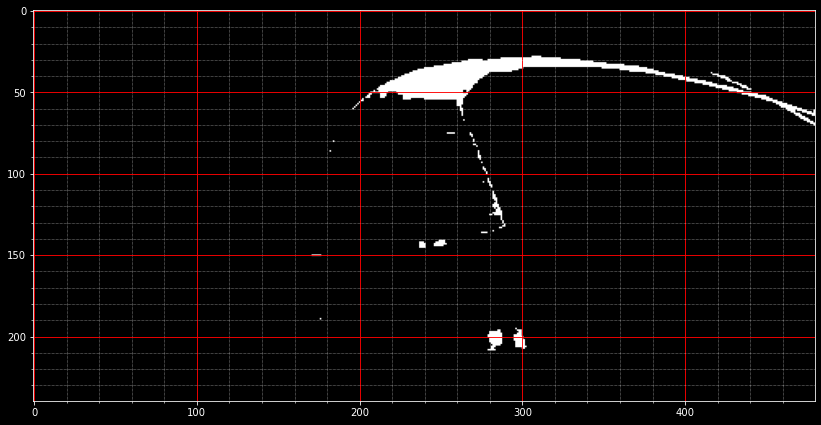

In [20]:
#probar la binarizacion en una imagen del video
img = cv.imread('figuras/imagen1_0.jpg')
img_bin = binarizacion(img)
fig, ax = plt.subplots(figsize = (14, 14))
ax.imshow(img_bin, cmap = 'gray')
ax.minorticks_on()
ax.grid(which = 'major', linestyle = '-', linewidth = '0.9', color = 'red')
ax.grid(which = 'minor', linestyle = ':', linewidth = '0.5', color = 'white')

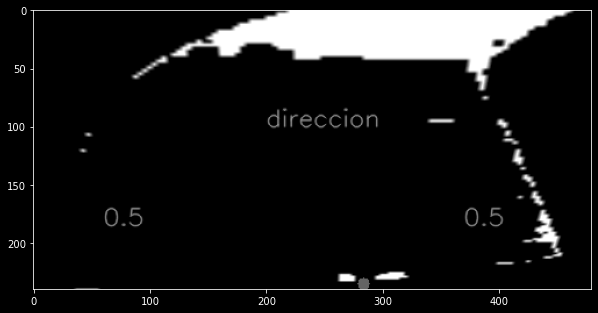

In [21]:
imagen = 'figuras/imagen1_0.jpg'

img = cv.imread(imagen)

img_bin = binarizacion(img)
img_interes = area_interes(img_bin)
mid_point = punto_medio(img_interes)

#textos
text1 = str(0.50)
text2 = str(0.50)
text3 = 'direccion'

#agregamos el tipo de fuente
font = cv.FONT_HERSHEY_SIMPLEX

#origen de cada texto
org1 = (60, 185)
org2 = (370, 185)
org3 = (200, 100)

#tamaño 
fontScale = 0.7

#color de la fuente
color = (150, 150, 150)

#grosor
thickness = 1

#usamos la funcion 'cv.putText()' que permitirá agregar texto
cv.putText(img_interes, text1, org1, font, fontScale,
              color, thickness, cv.LINE_AA, False)
cv.putText(img_interes, text2, org2, font, fontScale,
              color, thickness, cv.LINE_AA, False)
cv.putText(img_interes, text3, org3, font, fontScale,
              color, thickness, cv.LINE_AA, False)

plt.figure(figsize = (10, 7))
cv.circle(img_interes, (mid_point, 235), 5, (100, 100, 100), -1);
plt.imshow(img_interes, cmap = 'gray')
plt.show()

# Recopilación de imágenes

In [22]:
#Captura todas las frames del video
vidcap = cv.VideoCapture(filePath)
success,image = vidcap.read()
count = 0
while success:
    cv.imwrite("all_frames_act3/stop_test_frame%d.jpg" % count, image)     # save frame as JPEG file      
    success,image = vidcap.read()
    print('Read a new frame: ', success)
    count +=1


  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a ne